# Portfolio with the Maximum Calmar Ratio for the PSU Banks Sector

In [9]:
from pandas_datareader import data
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [10]:
# Establishing Dates
start = "2017-01-01"
end = "2021-1-1"

# Establishing Assets
assets = ['SBIN.NS', 'BANKBARODA.NS', 'CANBK.NS', 'PNB.NS', 'UNIONBANK.NS',
         'BANKINDIA.NS', 'INDIANB.NS', 'IOB.NS', 'CENTRALBK.NS', 'MAHABANK.NS']



#252 trading days in a year
N = 252

#1% risk free rate
rf =0.02

# Creating an empty dataframe
df_prices = pd.DataFrame()

# Getting the "Adj Close" data from Yahoo Finance by defining a function
# This function lists the price data as daily percent change 
def YahooData(dataframe, assets_list, start_date, end_date):
    for i in assets_list:
        dataframe[i] = data.DataReader(i, data_source = "yahoo", start=start_date, end=end_date)['Adj Close']
    return dataframe

# Running the function that we just made and saving the results to the DataFrame
df = YahooData(df_prices, assets, start, end)

# Calculating Log Return
df = np.log(df/df.shift(1))

# Dropping the first row because it's N/A
df = df.dropna()

# Viewing df head
df

SBIN.NS  BANKBARODA.NS  CANBK.NS    PNB.NS  UNIONBANK.NS  \
Date                                                                    
2017-01-03  0.005322      -0.002017  0.008914  0.020972      0.005560   
2017-01-04 -0.008200      -0.004046 -0.003405 -0.024005     -0.005560   
2017-01-05  0.010036       0.019736  0.009241  0.020610      0.018545   
2017-01-06  0.002239       0.015122  0.014906  0.011829      0.009726   
2017-01-09  0.004666      -0.002941 -0.001295  0.005863     -0.011682   
...              ...            ...       ...       ...           ...   
2020-12-28  0.030811       0.025154  0.036589  0.029759      0.019868   
2020-12-29  0.009763      -0.000802  0.008744  0.024391      0.044879   
2020-12-30 -0.003605      -0.004018  0.023466 -0.013647      0.001566   
2020-12-31 -0.007067      -0.010522 -0.003097  0.009119     -0.012599   
2021-01-01  0.016055       0.048441  0.033178  0.051596      0.017282   

            BANKINDIA.NS  INDIANB.NS    IOB.NS  CENTRALBK.NS  MAHABANK.NS  
Date                                                                       
2017-01-03      0.008341    0.006270  0.010299     -0.007117     0.003436  
2017-01-04     -0.006017    0.007561 -0.004107     -0.002981     0.000000  
2017-01-05      0.017032    0.008163  0.010236      0.000000     0.003425  
2017-01-06      0.009087    0.028592  0.000000     -0.003589    -0.001711  
2017-01-09      0.005862    0.003411  0.008114     -0.001199     0.005124  
...                  ...         ...       ...           ...          ...  
2020-12-28      0.010173    0.023450  0.009390      0.014337     0.003766  
2020-12-29      0.000000   -0.001697 -0.009390     -0.010734    -0.011342  
2020-12-30     -0.004057   -0.014257 -0.009479     -0.010850    -0.007634  
2020-12-31     -0.010215   -0.015630  0.018868      0.007246     0.000000  
2021-01-01      0.029339    0.030453  0.009302      0.017890     0.044951  

[988 rows x 10 columns]

In [11]:
# Creating 10000 random simulations of each portfolio weight configuration
num_runs = 10000 # number of rows/iterations

# Creating a Matrix with 10000 rows, with each row representing a random portfolio:
    #first 3 columns are Mean Returns, Standard Deviation, and Sortino Ratio
    # remaining columns are each assets random weight within that random portfolio
result = np.zeros((num_runs,(len(assets)+3)))
result

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
df = df.copy()

for i in range(num_runs):
    
    # randomized weights
    weights = np.array(np.random.random(len(assets))) 
    #Rebalance w/ constraints (SUM of all weights CANNOT BE > 1)
    weights = weights/np.sum(weights)
    
    ### daily return of the portfolio based on a given set of weights
    df['portfolio_ret'] = df.iloc[:,0]*weights[0]+df.iloc[:,1]*weights[1]+df.iloc[:,2]*weights[2]
  
                       
    # Calculating mean
    E = df['portfolio_ret'].mean()
    
    
    # Annualizing mean
    E = E*252
    

    
    # Calculating Drawdown
    def max_drawdown(return_series):
        comp_ret = (return_series+1).cumprod()
        peak = comp_ret.expanding(min_periods=1).max()
        dd = 1 - (comp_ret/peak)
        return dd.max()

    max_drawdown = max_drawdown(df['portfolio_ret'])
   
    #Calculating Annualised Calmar
    Calmar = E / max_drawdown
    
                   
    # Populating the 'result' array with the required values: Mean, Drawdown, Calmar followed by the weights                   
    result[i,0] = E
    result[i,1] = max_drawdown
    result[i,2] = Calmar
    
    for j in range(len(assets)):
        result[i,j+3]= weights[j]

In [13]:
# Converting 'result' into a DataFrame

columns = ['Mean','Drawdown', 'Calmar'] + assets

result = pd.DataFrame(result,columns=columns)
result

Mean  Drawdown    Calmar   SBIN.NS  BANKBARODA.NS  CANBK.NS  \
0    -0.051149  0.414349 -0.123444  0.069221       0.186543  0.086461   
1    -0.020749  0.304284 -0.068188  0.151420       0.078437  0.059386   
2    -0.003964  0.180797 -0.021924  0.145852       0.034632  0.012564   
3    -0.038739  0.339132 -0.114229  0.024115       0.064678  0.157300   
4    -0.050469  0.374480 -0.134771  0.016266       0.170673  0.090726   
...        ...       ...       ...       ...            ...       ...   
9995 -0.029880  0.319379 -0.093556  0.085038       0.073830  0.105640   
9996 -0.031480  0.284901 -0.110495  0.069042       0.148253  0.016308   
9997 -0.061702  0.542129 -0.113814  0.156417       0.179919  0.178604   
9998 -0.052228  0.404697 -0.129054  0.025375       0.143306  0.138527   
9999 -0.017250  0.319127 -0.054053  0.213132       0.112785  0.008084   

        PNB.NS  UNIONBANK.NS  BANKINDIA.NS  INDIANB.NS    IOB.NS  \
0     0.138675      0.102951      0.063009    0.073160  0.079343   
1     0.109060      0.133642      0.187038    0.193770  0.029644   
2     0.127613      0.108286      0.162977    0.017844  0.189976   
3     0.169827      0.058559      0.019818    0.122265  0.029513   
4     0.048096      0.050609      0.170975    0.248838  0.078774   
...        ...           ...           ...         ...       ...   
9995  0.149631      0.033356      0.012722    0.100068  0.209466   
9996  0.046416      0.173764      0.038231    0.110380  0.136178   
9997  0.036643      0.018184      0.004861    0.116866  0.072223   
9998  0.070429      0.153389      0.075549    0.089965  0.158090   
9999  0.071635      0.020244      0.032482    0.004606  0.161817   

      CENTRALBK.NS  MAHABANK.NS  
0         0.093507     0.107131  
1         0.036319     0.021285  
2         0.076794     0.123461  
3         0.138199     0.215725  
4         0.120540     0.004504  
...            ...          ...  
9995      0.085760     0.144489  
9996      0.131639     0.129789  
9997      0.146967     0.089316  
9998      0.010079     0.135290  
9999      0.167001     0.208214  

[10000 rows x 13 columns]

In [14]:
Max_Calmar = result.iloc[result['Calmar'].idxmax()]
Max_Calmar

Mean             0.006104
Drawdown         0.162379
Calmar           0.037588
SBIN.NS          0.185112
BANKBARODA.NS    0.000625
CANBK.NS         0.004020
PNB.NS           0.100611
UNIONBANK.NS     0.133350
BANKINDIA.NS     0.238652
INDIANB.NS       0.099200
IOB.NS           0.113812
CENTRALBK.NS     0.054355
MAHABANK.NS      0.070263
Name: 9825, dtype: float64

In [15]:
Min_Drawdown = result.iloc[result['Drawdown'].idxmin()]
Min_Drawdown

Mean            -0.002275
Drawdown         0.022155
Calmar          -0.102669
SBIN.NS          0.003425
BANKBARODA.NS    0.009459
CANBK.NS         0.002432
PNB.NS           0.144587
UNIONBANK.NS     0.248696
BANKINDIA.NS     0.129777
INDIANB.NS       0.037671
IOB.NS           0.245198
CENTRALBK.NS     0.136338
MAHABANK.NS      0.042416
Name: 8709, dtype: float64

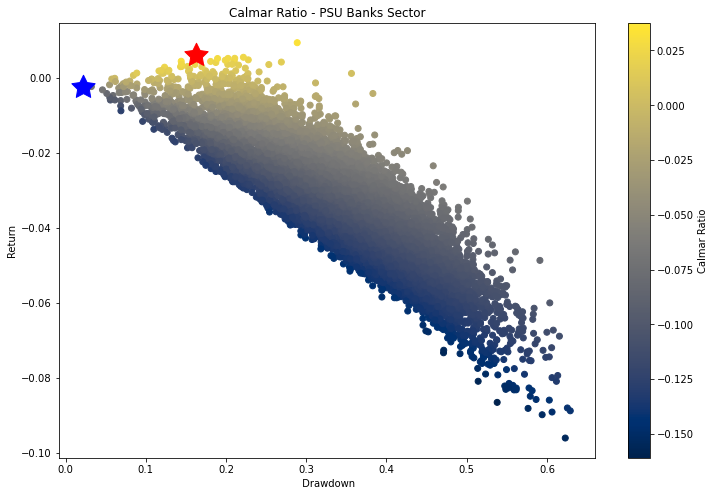

In [16]:
plt.figure(figsize=(12,8))
plt.scatter(x=result['Drawdown'],y=result['Mean'],c=result['Calmar'],cmap='cividis')
plt.colorbar(label='Calmar Ratio')
plt.xlabel(' Drawdown')
plt.ylabel('Return')

plt.title('Calmar Ratio - PSU Banks Sector')
#Plot a red star to highlight position of the portfolio with highest Sortino Ratio
plt.scatter(Max_Calmar[1],Max_Calmar[0],marker=(5,1,0),color='r',s=600)

#Plot a blue star to highlight position of the portfolio with minimum Variance
plt.scatter(Min_Drawdown[1],Min_Drawdown[0],marker=(5,1,0),color='b',s=600)
plt.show()